In [2]:
import numpy as np
import pandas as pd
import os
import anndata as ad
import scanpy as sc
import squidpy as sq

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as clr
from matplotlib.pyplot import rc_context
import glasbey

import gc
import scvi
import torch
from lightning.pytorch import seed_everything

c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\cupy\_environment.py:217: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\numba\core\decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
c

In [3]:
torch.set_float32_matmul_precision('high')
torch.cuda.is_available()
seed_everything(12345)
sc.settings.n_jobs = 12

Seed set to 12345


For vizualization purposes *only* split each compartment and do the scanvi integration/umap with the labels; we will then show this umap for the figures to summarise the annotations since the extensive subclustering previously done involves cleaning up missassignments across compartments.

In [3]:
Stroma = sc.read_h5ad("../../data/merfish/BAYSOR/reclustering/visualization/Stroma.baysor_reclustered.final.h5ad")

In [26]:
adata_filt = Stroma[:, Stroma.var['in_both_panels']].copy()

In [27]:
scvi.model.SCVI.setup_anndata(adata_filt, layer="counts", batch_key="batch", categorical_covariate_keys=['gene_panel'])
model = scvi.model.SCVI(adata_filt, n_layers=2)
model.train(accelerator='gpu')
model.save(f'../../data/merfish/BAYSOR/reclustering/visualization/Stroma_scvi_model', overwrite=True)
gc.collect()

c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\scvi\model\_scvi.py:159: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  library_log_means, library_log_vars = _init_library_size(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Epoch 15/15: 100%|██████████| 15/15 [09:25<00:00, 37.42s/it, v_num=1, train_loss_step=68.6, train_loss_epoch=72]  

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 15/15: 100%|██████████| 15/15 [09:25<00:00, 37.73s/it, v_num=1, train_loss_step=68.6, train_loss_epoch=72]


3275

In [28]:
model = scvi.model.SCVI.load(f'../../data/merfish/BAYSOR/reclustering/visualization/Stroma_scvi_model', adata=adata_filt)

INFO     File ../../data/merfish/BAYSOR/reclustering/visualization/Stroma_scvi_model\model.pt already downloaded   


c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\scvi\model\_scvi.py:159: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  library_log_means, library_log_vars = _init_library_size(


In [29]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(model, adata=adata_filt, labels_key="cell_type.detailed", unlabeled_category="Unknown")
scanvi_model.train(accelerator='gpu')
scanvi_model.save(f'../../data/merfish/BAYSOR/reclustering/visualization/Stroma_scanvi_model', overwrite=True)
gc.collect()

c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\scvi\model\_scanvi.py:139: UserWarning: This dataset has some empty cells, this might fail inference.Data should be filtered with `scanpy.pp.filter_cells()`
  library_log_means, library_log_vars = _init_library_size(self.adata_manager, n_batch)


INFO     Training for 5 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Paula\miniconda3\envs\rapids\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Epoch 5/5: 100%|██████████| 5/5 [08:32<00:00, 99.33s/it, v_num=1, train_loss_step=86.4, train_loss_epoch=84.2] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [08:32<00:00, 102.49s/it, v_num=1, train_loss_step=86.4, train_loss_epoch=84.2]


4819

In [30]:
adata_filt.obsm['reclust_scvi'] = model.get_latent_representation()
adata_filt.obsm['reclust_scanvi'] = scanvi_model.get_latent_representation()

In [31]:
Stroma.obsm['reclust_scvi'] = adata_filt.obsm['reclust_scvi'].copy()
Stroma.obsm['reclust_scanvi'] = adata_filt.obsm['reclust_scanvi'].copy()
del adata_filt
gc.collect()

0

In [32]:
sc.pp.neighbors(Stroma, use_rep = f'reclust_scanvi',  n_neighbors=30, random_state=12345)
sc.tl.umap(Stroma, min_dist=0.1, key_added='reclust_scanvi_umap', random_state=12345)

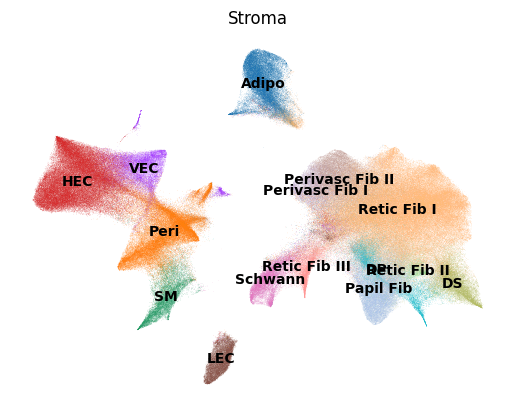

In [33]:
sc.pl.embedding(Stroma, basis='reclust_scanvi_umap', color='cell_type.detailed', legend_loc='on data', title='Stroma', frameon=False, show=True)

In [36]:
Stroma.write_h5ad("../../data/merfish/BAYSOR/reclustering/visualization/Stroma.baysor_reclustered.final.h5ad", compression='gzip')

In [4]:
Stroma = sc.read_h5ad("../../data/merfish/BAYSOR/reclustering/visualization/Stroma.baysor_reclustered.final.h5ad")

In [4]:
Stroma.X = Stroma.layers['counts'].copy()
sc.pp.normalize_total(Stroma)
sc.pp.log1p(Stroma)
Stroma.layers['log1p'] = Stroma.X.copy()
sc.pp.highly_variable_genes(Stroma, n_top_genes=500, batch_key = 'batch', subset=False)
sc.pp.scale(Stroma, max_value=10)
Stroma.layers['scaled'] = Stroma.X.copy()

In [5]:
import scanpy.external as sce
sc.tl.pca(Stroma, n_comps=30, mask_var='in_both_panels', key_added='pca')
sce.pp.harmony_integrate(Stroma, key='batch', basis='pca', adjusted_basis='reclust_harmony')
sc.pp.neighbors(Stroma, use_rep = f'reclust_harmony', n_pcs=30, n_neighbors=50, random_state=12345)


2025-04-29 10:42:27,719 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-04-29 10:42:58,761 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-04-29 10:43:00,816 - harmonypy - INFO - Iteration 1 of 10
2025-04-29 10:46:24,201 - harmonypy - INFO - Iteration 2 of 10
2025-04-29 10:49:46,582 - harmonypy - INFO - Converged after 2 iterations


In [9]:
sc.tl.umap(Stroma, min_dist=0.1,negative_sample_rate=10, key_added=f'reclust_harmony_umap', random_state=12345)

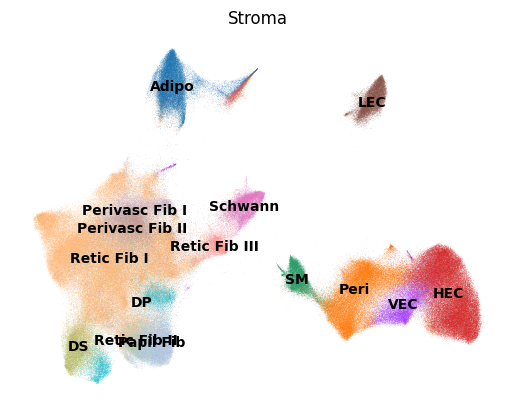

In [12]:
sc.pl.embedding(Stroma, basis='reclust_harmony_umap', color='cell_type.detailed', legend_loc='on data', title='Stroma', frameon=False, show=True)

In [13]:
Stroma.write_h5ad("../../data/merfish/BAYSOR/reclustering/visualization/Stroma.baysor_reclustered.final.h5ad", compression='gzip')